In [1]:
import Pkg; Pkg.add(["Plots"]);
import Logging; Logging.disable_logging(Logging.Info)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Project.toml`
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Manifest.toml`


LogLevel(1)

In [2]:
const STATIC_LECTURE = true;

In [3]:
using LinearAlgebra;
using Plots; plotlyjs(); default(l=5, size=(900,550), label=false);
using Printf;
using Polynomials;

BLAS.set_num_threads(1)

if STATIC_LECTURE
    default(fmt=:png)
end

prettyprint(a) = map(x -> @sprintf("%+.2f", x), v)

function imshow(x; kwargs...)
    return heatmap(x
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=:diverging_gwv_55_95_c39_n256
        ; kwargs...
    )
end
p = plot!([0,1],[0,1]);

WebIO._IJuliaInit()

### Warmup

# Stability of Householder Triangularization & Back Substitution

## Review

### Backward Error Analysis

Forward relative error ...

$$
\frac{\|\tilde{f}(x) - f(x)\|}{\|f(x)\|}
\leq
\frac{\|\tilde{f}(x) - f(\tilde x)\|}{\|f(x)\|}
+
\frac{\|f(\tilde{x}) - f(x)\|}{\|f(x)\|}
$$

$$
\leq
\frac{\|\tilde{f}(x) - f(\tilde x)\|}{\|f(x)\|}
+
(\kappa(x) + o(1))\frac{\|\tilde{x} - x\|}{\|x\|}
$$

$$
\underbrace{\frac{\|\tilde{f}(x) - f(\tilde x)\|}{\|f(x)\|}}_{\substack{O(\epsilon_{\text{machine}}) \\ \text{if (backward) stable}}}
+
\underbrace{(\kappa(x) + o(1))}_{O(\kappa(x))}\underbrace{\frac{\|\tilde{x} - x\|}{\|x\|}}_{\substack{O(\epsilon_{\text{machine}}) \\ \text{if (backward) stable}}}
= O(\kappa(x) \epsilon_{\text{machine}})
$$

... is bounded by the product of conditioning and backward relative error for stable algorithms

### Review: forward and backward errors of Householder QR

In [4]:
n_samples = 100; m_min = 10; m_max = 50

conds = Float64[]; Q_errs = Float64[]
R_rel_errs = Float64[]; A_rel_errs = Float64[]
for i in 1:n_samples
    # random size, Q, and R
    m = rand(m_min:m_max)
    R = triu(randn(m, m)); Q = qr(randn(m, m)).Q
    # construct A
    A = Q * R
    # algorithm: Householder QR
    Q2, R2 = qr(A)
    # fix signs
    signs = diagm(sign.(diag(R)).*sign.(diag(R2)))
    Q2 = Q2 * signs; R2 = signs * R2
    # compute errors 
    Q_err = norm(Q2 - Q)
    R_rel_err = norm(R2 - R) / norm(R)
    A_rel_err = norm(A - Q2 * R2) / norm(A)
    push!(conds, cond(A))
    push!(Q_errs, Q_err)
    push!(R_rel_errs, R_rel_err)
    push!(A_rel_errs, A_rel_err)
end

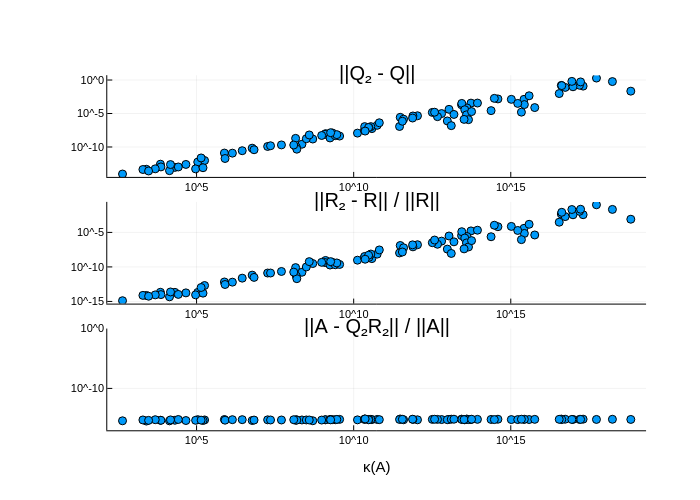

In [5]:
q = plot(conds, Q_errs
    , st = :scatter
    , title = "||Q₂ - Q||"
)
r = plot(conds, R_rel_errs
    , st = :scatter
    , title = "||R₂ - R|| / ||R||"
)
a = plot(conds, A_rel_errs
    , st = :scatter
    , title = "||A - Q₂R₂|| / ||A||"
    , ylim = (1.e-17, 1.e0)
    , xlabel = "κ(A)"
)
plot(q, r, a, layout=(3,1)
    , scale = :log10

    , size = (600,600)
)

- Small backward errors (stable), forward errors $\propto \kappa(A)$

### T&B Theorem 16.1

Let the QR factorization $A = QR$ of a matrix $A \in \mathbb{C}^{m \times n}$ be computed by Householder triangularization on a computer satisfying the floating point axioms, and let the computed $\tilde{Q}$ be

$$
\tilde{Q} = \tilde{Q}_1 \tilde{Q}_2 \dots \tilde{Q}_n,
$$

where $\tilde{Q}_k$ is the Householder reflector of the computed reflector $\tilde{v}_k$.  Then

$$\tilde{Q}\tilde{R} = A + \delta A, \quad \frac{\|\delta A\|}{\|A\|} = O(\epsilon_{\text{machine}}), \quad \text{[backward stability]}$$

for some $\delta A \in \mathbb{C}^{m \times n}$.

### Details on $\tilde{Q}_k$

- In Householder QR the solution is not a computed $Q$, it is the Householder reflectors $v_k$ that define
$Q_k$:

$$Q = Q_1 Q_2 \cdots Q_n.$$

- $\tilde{Q}_k$ is the _exactly unitary_ matrix for the computed vector $\tilde{v}_k$
- so $\tilde{Q}$ is _exactly unitary_, even though $\tilde{Q} \neq Q$ (as demonstrated in the experiment)

## Analyzing Solving $Ax = b$ with Householder QR

> QR factorization is generally not an end itself, but a means to other ends such as solution of a system of equations [...]

> Is its backward stability enough to make it a satisfactory piece of a larger algorithm? [...] or do we need accuracy of $Q$ and $R$ individually?

### Solving $Ax = b$ with Householder QR

In [6]:
function householder_solve(A, b)
    Q, R = qr(A) # Factor A by Householder triangularization
    y = Q' * b   # Compute Q* b by applying the reflectors in order
    x = R \ y    # Solve the triangular system R x = y by back substitution
    return x
end;

**Backward stability of steps (takes as given for now):**

1. $\tilde{Q}, \tilde{R} \gets QR(A)$: just stated as T&B Theorem 16.1

2. $\tilde y \gets \tilde{Q}^* b$: yes (**HW 3 Q 6**, roughly)

$$(\tilde{Q} + \delta Q) \tilde y = b, \quad \|\delta Q\| = O(\epsilon_{\text{machine}})$$

3. $\tilde x \gets \tilde{R}^{-1} \tilde y$: yes (coming up next),

$$(\tilde R + \delta R) \tilde x = \tilde y, \quad \frac{\|\delta R\|}{\|\tilde R\|} = O(\epsilon_{\text{machine}}).$$

### T&B Theorem 16.2.

`householder_solve` is backwardstable, satisfying

$$
(A + \Delta A) \tilde x = b, \quad \frac{\|\Delta A\|}{\|A\|} = O(\epsilon_{\text{machine}})
$$

for some $\Delta A \in \mathbb{C}^{m \times m}$.

$$
\begin{aligned}
A + \delta A &= \tilde Q \tilde R &\star\\
(\tilde Q + \delta Q) \tilde y &= b &\clubsuit \\
(\tilde R + \delta R) \tilde x &= \tilde y & \spadesuit
\end{aligned}
$$

_Proof._ 

Combine $\clubsuit$, $\spadesuit$:

$$
b = (\tilde Q + \delta Q)(\tilde R + \delta R) \tilde x = [\tilde Q \tilde R + (\delta Q) \tilde R + \tilde Q (\delta R) + (\delta Q)(\delta R)]\tilde x
$$

Apply $\star$:

$$
b = [A + \underbrace{\delta A + (\delta Q) \tilde R + \tilde Q (\delta R) + (\delta Q)(\delta R)}_{\Delta A}]\tilde x
$$

We want $\|\Delta A\| / \|A\| = O(\epsilon_{\text{machine}})$, will show each of the four terms is $O(\epsilon_{\text{machine}})$

$$\frac{\|\delta A\|}{\|A\|} = O(\epsilon_{\text{machine}})\quad[\star]$$

$$
\frac{\|(\delta Q) \tilde R\|}{\|A\|} \leq
\|\delta Q\| \frac{\|\tilde R\|}{\|A\|} =
\|\delta Q\| \frac{\|\tilde{Q}^*(A + \delta A)\|}{\|A\|}
=
\underbrace{\|\delta Q\|}_{O(\epsilon_{\text{machine}}) [\clubsuit]} \underbrace{\frac{\|A + \delta A\|}{\|A\|}}_{O(1)}
= O(\epsilon_{\text{machine}})
$$

$$
\frac{\|\tilde{Q}(\delta R)\|}{\|A\|} =
\frac{\|\delta R\|}{\|A\|} = \underbrace{\frac{\|\delta R\|}{\|\tilde R\|}}_{O(\epsilon_{\text{machine}}) [\spadesuit]}\frac{\|\tilde R\|}{\|A\|} =O(\epsilon_{\text{machine}})
$$

$$\frac{\|(\delta Q)(\delta R)\|}{\|A\|} \leq
\|(\delta Q)\|\frac{\|(\delta R)\|}{\|A\|} = O(\epsilon_{\text{machine}}^2)
$$

### Now applying our backward error analysis theorem

**T&B Theorem 16.3.** The computed solution $\tilde{x}$ of `householder_solve` satisfies

$$\frac{\|\tilde x - x\|}{\|x\|} = O(\kappa(A) \epsilon_{\text{machine}}).$$

## Stability of Back Substitution

### Triangular Systems

We wish to solve $Rx = b$,

$$
\begin{bmatrix}
r_{11} & r_{12} & \cdots & r_{1m} \\
       & r_{22} &        & \vdots \\
       &        & \ddots & \vdots \\
       &        &        & r_{mm}
\end{bmatrix}
\begin{bmatrix}
x_1 \\ x_2 \\ \vdots \\ x_m
\end{bmatrix}
=
\begin{bmatrix}
b_1 \\ b_2 \\ \vdots \\ b_m
\end{bmatrix}
$$

Subproblem of:

- Solving $Ax = b$ / least squares by QR
- Solving $Ax = b$ by LU (Gaussian elimination)
- Solving $Ax = b$ by Cholesky

In [7]:
function backsubstitution(R, b)
    m = length(b)
    x = copy(b)
    for j = m:-1:1
        x[j] /= R[j,j]
        for i = 1:j-1
            x[i] -= R[i,j] * x[j]
        end
    end
    return x
end;

In [8]:
function backsubstitution_vec(R, b)
    m = length(b)
    x = copy(b)
    for j = m:-1:1
        x[j] /= R[j,j]
        x[1:j-1] -= R[1:j-1,j] * x[j]
    end
    return x
end;

These two algorithms are floating-point identical.  They differ from backslash only in the order of subtractions:

In [9]:
m = 100;
R = qr(randn(m,m)).R

b = randn(m)
x_backslash = R \ b
x_backsub = backsubstitution(R, b)
x_backsubv = backsubstitution_vec(R, b)
display(norm(x_backslash - x_backsub) / norm(x_backslash))
display(norm(x_backslash - x_backsubv) / norm(x_backslash))

4.761811772240387e-16

4.761811772240387e-16

### T&B Theorem 17.1.

Suppose $b = \mathrm{fl}(b)$ and $R = \mathrm{fl}(R)$.  `backsubstitution` is backward stable:

$$(R + \delta R) \tilde x = b$$

for some upper-triangular $\delta R$ with

$$\frac{\|\delta R\|}{\|R\|} = O( \epsilon_{\text{machine}} ).$$

Elementwise,

$$
\frac{|\delta r_{ij}|}{|r_{ij}|} \leq m \epsilon_{\text{machine}} + O(\epsilon^2).
$$

### Exercise

What does this theorem imply about $\|\tilde x - x\| / \|x\|$?

In [10]:
n_samples = 100; m_min = 10; m_max = 50

conds = Float64[]; 
x_rel_errs = Float64[]; b_rel_errs = Float64[]
for i in 1:n_samples
    # random size, R, and x
    m = rand(m_min:m_max)
    # construct b
    # algorithm: backsubstitution
    # compute errors 
    push!(conds, cond(R))
end

In [11]:
x = plot(conds, x_rel_errs
    , st = :scatter
    , title = "||x₂ - x|| / ||x||"
)
b = plot(conds, b_rel_errs
    , st = :scatter
    , title = "||b - R x₂|| / ||R||"
    , ylim = (1.e-17, 1.e0)
    , xlabel = "κ(A)"
)
plot(x, b, layout=(2,1)
    , scale = :log10

    , size = (600,600)
)

┌ Warning: No strict ticks found
└ @ PlotUtils /home/tisaac/.julia/packages/PlotUtils/xekml/src/ticks.jl:333


BoundsError: BoundsError: attempt to access 0-element Vector{Float64} at index [1:100]

Remember we are trying to prove $(R + \delta R)\tilde x = b$: accumulate backward errors into $\tilde{R}$

### A useful lemma (Higham)

If $|\epsilon_i| \leq \epsilon_{\text{machine}}$ for each $i$ and $\rho_i = \pm 1$, then

$$
\prod_{i=1}^n (1 + \epsilon_i)^{\rho_i} = (1 + \theta_n), \quad |\theta_n| \leq \frac{n\epsilon_{\text{machine}}}{1 - n\epsilon_{\text{machine}}} =: \gamma_n = n \epsilon_{\text{machine}} + O(\epsilon_{\text{machine}}^2).
$$

We can treat $(1 + \epsilon_i)^{-1}$ and $(1 + \epsilon)$ the same!

If $\theta_n$ appears twice in the same expression, such as $x(1 + \theta_n) + y(1 + \theta_n)$, each one represents a different accumulated error.

## $m = 1$

$$\tilde{x}_1 \gets b_1 \bigcirc\!\!\!\!\!\!\div\ \ r_{11}$$

By floating point axiom,

$$\tilde x_1 = (b_1 / r_{11})(1 + \epsilon_1) = b_1 / (r_{11}(1 + \epsilon_1)^{-1})$$

By our useful lemma,

$$\tilde{x}_1 = b_1 / (r_{11}(1 + \theta_1)) \Rightarrow (r_{11} + \theta_1 r_{11}) \tilde{x}_1 = b_1.$$

$$\frac{|\theta_1 r_{11}|}{|r_{11}|} = |\theta_1| \leq \gamma_1 = \epsilon_{\text{machine}} + O(\epsilon_{\text{machine}}^2).$$

### $m = 2$

The prevous case is now used in row 2,

$$
\tilde{x}_2 = b_2 / (r_{22}(1 + \theta_1))
$$

The next step:

$$\tilde{x}_1 = (b_{1} \bigcirc\!\!\!\!\!\!\!-\ \ (\tilde{x}_2 \otimes r_{12})) \bigcirc\!\!\!\!\!\!\div\ \ r_{11}$$

$$\tilde{x}_2 \otimes r_{12} = \tilde{x}_2 r_{12} (1 + \epsilon_2)$$

$$b_1 \bigcirc\!\!\!\!\!\!\!-\ \ \tilde{x}_2 r_{12}(1 + \epsilon_2) =
(b_1 - \tilde{x}_2 r_{12}(1 + \epsilon_2))(1 + \epsilon_3)$$

$$b_1 \bigcirc\!\!\!\!\!\!\!-\ \ \tilde{x}_2 r_{12}(1 + \epsilon_2) =
(b_1 - \tilde{x}_2 r_{12}(1 + \epsilon_2))(1 + \epsilon_3)$$

$$
\begin{aligned}
(b_1 - \tilde{x}_2 r_{12}(1 + \epsilon_2))(1 + \epsilon_3) \bigcirc\!\!\!\!\!\!\div\ \ r_{11}
&= \frac{(b_1 - \tilde{x}_2 r_{12}(1 + \epsilon_2))}{r_{11}}(1 + \epsilon_3)(1 + \epsilon_4)\\ &=
\frac{(b_1 - \tilde{x}_2 r_{12}(1 + \epsilon_2))}{r_{11}(1 + \theta_2)}
\end{aligned}$$

$$
\begin{aligned}
\Rightarrow r_{11}(1 + \theta_2)\tilde{x}_1 + r_{12}(1 + \epsilon_2)\tilde x_2 &= b_1 \\
r_{22}(1 + \theta_1) \tilde{x}_2 &= b_2.
\end{aligned}
$$

$$
[R \odot (I + \Theta_2)] \tilde x = b,
$$

- $\odot$ Hadamard (pointwise) product of matrices
- $\Theta_k$ upper triangular $k \times k$ matrix whose entries are $\theta_k$

### $m = 3, \dots$

$$\tilde{x}_1 = (\cdots ((b_{1} \bigcirc\!\!\!\!\!\!\!-\ \ (\tilde{x}_m \otimes r_{1m})) \bigcirc\!\!\!\!\!\!\!-\ \ (\tilde{x}_{m-1} \otimes r_{1{m-1}})) \bigcirc\!\!\!\!\!\!\!-\ \ \cdots \bigcirc\!\!\!\!\!\!\!-\ \ (\tilde{x}_2 \otimes r_{12})) \bigcirc\!\!\!\!\!\!\div\ \ r_{11}$$

(our `backsubstitution` does the updates in the opposite order of the book)

What we had in the top row of the $m=2$ case can generalize like

$$
\begin{aligned}
\tilde{x}_1 &= \left([b_1 - \{r_{1,3:m} \odot (1 + \vec{\theta}_{m-2})\} \cdot\tilde{x}_{3:m}] (1 + \theta_{m-2}) \bigcirc\!\!\!\!\!\!\!-\ \ (r_2 (1 + \epsilon_1)) \cdot \tilde x_2\right) \bigcirc\!\!\!\!\!\!\div\ \ r_{11}
\\
&= \frac{\left([b_1 - \{r_{1,3:m} \odot (1 + \vec{\theta}_{m-2})\} \cdot\tilde{x}_{3:m}] (1 + \theta_{m-2}) - (r_2 (1 + \epsilon_2)) \cdot \tilde x_2\right)}{r_{11}(1 + \theta_2)}
\end{aligned}
$$

where $\vec{\theta}_{m-2}$ is a vector with $\theta_{m-2}$ entries

we want to sneak that $(1 + \epsilon_1)$ term out so that it doesn't perturb $b_1$

Divide the top and the bottom by $(1 + \theta_{m-2})$, combining $(1 + \theta_{m-2})^{-1}(1 + \epsilon_2)$
into $(1 + \theta_{m-1})$:

$$
\begin{aligned}
\tilde{x}_1 
&= \frac{\left([b_1 - \{r_{1,3:m} \odot (1 + \vec{\theta}_{m-2})\} \cdot\tilde{x}_{3:m}] - (r_2 (1 + \theta_{m-1})) \cdot \tilde x_2\right)}{r_{11}(1 + \theta_m)}
\\
&= \frac{\left(b_1 - \{r_{1,3:m} \odot (1 + \vec{\theta}_{m-2})\} \cdot\tilde{x}_{3:m} - (r_2 (1 + \theta_{m-1})) \cdot \tilde x_2\right)}{r_{11}(1 + \theta_m)}
\\
&= \frac{\left(b_1 - \{r_{1,2:m} \odot (1 + \vec{\theta}_{m-1})\} \cdot\tilde{x}_{2:m}\right)}{r_{11}(1 + \theta_m)}
\end{aligned}
$$

This matches the inductive case and gives us the backward error form

$$
[R \odot (I + \Theta_m)] \tilde x = b,
$$